# 0. 초기 설정

## 1) Library imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold

from scipy.signal import savgol_filter, butter, filtfilt
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) 한글 폰트 설정

In [3]:
import matplotlib.font_manager as fm

font_path = '/content/drive/MyDrive/ML project/NanumGothic-Regular.ttf'

font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_name

## 3) 데이터 경로 설정

In [4]:
BASE_PATH = '/content/drive/MyDrive/ML project/'
FD001_PATH = os.path.join(BASE_PATH, 'train_FD001.txt')
FD001_TEST_PATH = os.path.join(BASE_PATH, 'test_FD001.txt')
FD001_RUL_PATH = os.path.join(BASE_PATH, 'RUL_FD001.txt')

FD004_PATH = os.path.join(BASE_PATH, 'train_FD004.txt')
FD004_TEST_PATH = os.path.join(BASE_PATH, 'test_FD004.txt')
FD004_RUL_PATH = os.path.join(BASE_PATH, 'RUL_FD004.txt')

## 4) 전역 설정

In [5]:
# random seed
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Sensor
ALL_SENSORS = [f's_{i}' for i in range(1, 22)]

# 각 센서별 최소 sequence length 확인 - FD001: 31, FD004: 19으로 확인하여 WINDOW_SIZE 20으로 설정
# FD004 데이터셋에서 sequence length가 19인 센서는 feature selection에서 제외 됨
WINDOW_SIZE = 20

# LSTM 모델 구조
LSTM_UNITS = 64
LSTM_LAYERS = 2
DENSE_UNITS = 32
DROPOUT = 0.2

# 학습 설정
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 100
PATIENCE = 10

# RUL Thresholds
RUL_THRESHOLDS = [50, 75, 100, 125, 150]

# Variance Threshold (for sensor selection)
VAR_THRESHOLD = 0.01

# 1. 데이터 로드 및 전처리 함수

## 데이터 로드

In [6]:
def load_cmapss_data(filepath):
    df = pd.read_csv(filepath, sep=r'\s+', header=None, engine='python')
    df = df.dropna(axis=1, how='all')

    n_cols = len(df.columns)
    n_sensors = n_cols - 5

    column_names = ['unit', 'cycle', 'setting_1', 'setting_2', 'setting_3'] + \
                   [f's_{i}' for i in range(1, n_sensors + 1)]

    df.columns = column_names

    df['unit'] = df['unit'].astype('int32')
    df['cycle'] = df['cycle'].astype('int32')

    max_cycles = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = (max_cycles - df['cycle']).astype('int32')

    return df

def load_test_rul(filepath):
    return np.loadtxt(filepath)

## 1) RUL clipping

In [7]:
def apply_rul_clipping(df, threshold):
    df_clipped = df.copy()
    df_clipped['RUL'] = df_clipped['RUL'].clip(upper=threshold)
    return df_clipped

## 2) Scaling

In [8]:
def apply_minmax_scaling(df, sensor_cols):
    df_scaled = df.copy()
    scaler = MinMaxScaler()
    df_scaled[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    return df_scaled

def apply_standard_scaling(df, sensor_cols):
    df_scaled = df.copy()
    scaler = StandardScaler()
    df_scaled[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    return df_scaled

def apply_robust_scaling(df, sensor_cols):
    df_scaled = df.copy()
    scaler = RobustScaler()
    df_scaled[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    return df_scaled

# Scaling Methods 딕셔너리
SCALING_METHODS = {
    'none': None,
    'minmax': apply_minmax_scaling,
    'standard': apply_standard_scaling,
    'robust': apply_robust_scaling
}

## 3) Filtering

In [9]:
def apply_moving_average(df, sensor_cols, window=5):
    df_filtered = df.copy()
    for col in sensor_cols:
        df_filtered[col] = df[col].rolling(window=window, min_periods=1, center=True).mean()
    return df_filtered

def apply_savgol_filter(df, sensor_cols, window=11, polyorder=3):
    df_filtered = df.copy()
    for col in sensor_cols:
        df_filtered[col] = savgol_filter(df[col].values, window_length=window,
                                         polyorder=polyorder, mode='nearest')
    return df_filtered

def apply_butterworth_filter(df, sensor_cols, cutoff=0.1, order=4):
    df_filtered = df.copy()
    b, a = butter(order, cutoff, btype='low')
    for col in sensor_cols:
        df_filtered[col] = filtfilt(b, a, df[col].values)
    return df_filtered

def apply_median_filter(df, sensor_cols, window=5):
    df_filtered = df.copy()
    for col in sensor_cols:
        df_filtered[col] = df[col].rolling(window=window, min_periods=1, center=True).median()
    return df_filtered

def apply_gaussian_filter(df, sensor_cols, sigma=2):
    df_filtered = df.copy()
    for col in sensor_cols:
        df_filtered[col] = gaussian_filter1d(df[col].values, sigma=sigma)
    return df_filtered

# 신호 지연이 발생하는 구간 탐지
def compute_curvature(signal):
    # 곡률(curvature)을 근사적으로 계산하는 2차 차분 방식
    return np.abs(2*signal[1:-1] - signal[:-2] - signal[2:])

def detect_delay_curvature(raw_signal, filtered_signal, threshold_scale=1.0, cycle_duration=20):
    curv_raw = compute_curvature(raw_signal)
    curv_filt = compute_curvature(filtered_signal)

    # 지연 감지 임계값: raw 곡률의 표준편차 기반으로 설정
    threshold = threshold_scale * np.std(curv_raw)

    # 지연 구간: raw는 급격한 변화가 있지만 filtered는 아직 따라오지 못하는 영역
    delay_mask = (curv_raw > threshold) & (curv_filt < curv_raw)

    # 연속된 지연 구간 추출
    delay_regions = []
    in_delay = False
    start_idx = 0

    for i, d in enumerate(delay_mask):
        if d and not in_delay:
            start_idx = i
            in_delay = True
        elif not d and in_delay:
            if i - start_idx >= cycle_duration:
                delay_regions.append((start_idx, i))
            in_delay = False

    if in_delay and len(delay_mask) - start_idx >= cycle_duration:
        delay_regions.append((start_idx, len(delay_mask)))

    return delay_regions

#센서별 지연 카운트
def count_delay_regions(train_data, sensors, FILTER_METHODS, detect_delay_func,threshold_scale=0.6, cycle_duration=15):
    filter_names = list(FILTER_METHODS.keys())
    delay_sensors = {f: {} for f in filter_names}

    for filter_name, filter_func in FILTER_METHODS.items():

        for sensor in sensors:

            # 필터 적용
            if filter_name == 'none':
                filtered = train_data.copy()
            else:
                filtered = filter_func(train_data.copy(), [sensor])

            raw_values = train_data[sensor].values
            filt_values = filtered[sensor].values

            # 지연 구간 탐지
            delay_regions = detect_delay_func(
                raw_values, filt_values,
                threshold_scale=threshold_scale,
                cycle_duration=cycle_duration
            )

            # 센서별 개수 저장
            delay_sensors[filter_name][sensor] = len(delay_regions)

    return delay_sensors

def plot_delay_compare(delay_counts_fd001, delay_counts_fd004, sensors, title="FD001 vs FD004 필터별 지연 구간 비교"):

    def remove_none(delay_counts):
        return {k: v for k, v in delay_counts.items() if k != "none"}

    delay_counts_fd001 = remove_none(delay_counts_fd001)
    delay_counts_fd004 = remove_none(delay_counts_fd004)

    filter_names = list(delay_counts_fd001.keys())

    # 두 데이터셋의 total sum을 계산하여 y축 최대값 통일
    def calc_totals(delay_counts):
        return np.array([sum(delay_counts[f].values()) for f in filter_names])

    totals_fd001 = calc_totals(delay_counts_fd001)
    totals_fd004 = calc_totals(delay_counts_fd004)

    y_max = max(totals_fd001.max(), totals_fd004.max()) * 1.15  # 여백 포함

    # figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle(title, fontsize=18, fontweight="bold")

    datasets = {
        "FD001": delay_counts_fd001,
        "FD004": delay_counts_fd004
    }

    for ax_idx, (dataset_name, delay_counts) in enumerate(datasets.items()):
        ax = axes[ax_idx]

        # stacked values 준비
        data = np.array([[delay_counts[f][s] for s in sensors] for f in filter_names])

        bottom = np.zeros(len(filter_names))
        colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(sensors)))

        for s_idx, sensor in enumerate(sensors):
            vals = data[:, s_idx]

            # stacked bar
            ax.bar(filter_names, vals, bottom=bottom, color=colors[s_idx], label=sensor)

            # segment 값 표시
            for i, val in enumerate(vals):
                if val > 0:
                    ax.text(
                        i,
                        bottom[i] + val / 2,
                        str(val),
                        ha="center",
                        va="center",
                        fontsize=8
                    )
            bottom += vals

        # 총 지연 개수 표시
        totals = data.sum(axis=1)
        for i, total in enumerate(totals):
            ax.text(i, total + y_max * 0.02, str(total),
                    ha="center", va="bottom", fontsize=10, fontweight="bold")

        ax.set_title(f"{dataset_name}", fontsize=14, fontweight="bold")
        ax.set_xticks(range(len(filter_names)))
        ax.set_xticklabels(filter_names, rotation=45, ha='right')
        ax.set_ylim(0, y_max)
        ax.set_ylabel("Delay Count")
        ax.grid(axis='y', alpha=0.3)

        # FD004 plot에만 legend 추가
        if ax_idx == 0:
            ax.legend(title="Sensor")

    plt.tight_layout()
    plt.show()

# Filter Methods 딕셔너리
FILTER_METHODS = {
    'none': None,
    'moving_avg': apply_moving_average,
    'savgol': apply_savgol_filter,
    'butterworth': apply_butterworth_filter,
    'median': apply_median_filter,
    'gaussian': apply_gaussian_filter
}

## 4) Feature engineering

In [10]:
def apply_rolling_statistics(df, sensor_cols, windows=[5, 10]):
    df_feat = df.copy()
    new_features = sensor_cols.copy()

    for window in windows:
        for col in sensor_cols:
            # Rolling mean
            col_mean = f'{col}_rolling_mean_{window}'
            df_feat[col_mean] = df[col].rolling(window=window, min_periods=1).mean()
            new_features.append(col_mean)

            # Rolling std
            col_std = f'{col}_rolling_std_{window}'
            df_feat[col_std] = df[col].rolling(window=window, min_periods=1).std().fillna(0)
            new_features.append(col_std)

    return df_feat, new_features

def apply_derivative_features(df, sensor_cols):
    df_feat = df.copy()
    new_features = sensor_cols.copy()

    for col in sensor_cols:
        # 1차 미분
        col_diff1 = f'{col}_diff1'
        df_feat[col_diff1] = df[col].diff().fillna(0)
        new_features.append(col_diff1)

        # 2차 미분
        col_diff2 = f'{col}_diff2'
        df_feat[col_diff2] = df[col].diff().diff().fillna(0)
        new_features.append(col_diff2)

    return df_feat, new_features

def apply_sensor_selection(df, sensor_cols, variance_threshold=0.01):
    df_feat = df.copy()

    # Variance Threshold
    selector = VarianceThreshold(threshold=variance_threshold)
    selector.fit(df[sensor_cols])

    # 선택된 센서
    selected_mask = selector.get_support()
    selected_sensors = [col for col, selected in zip(sensor_cols, selected_mask) if selected]

    return df_feat, selected_sensors

# Feature Engineering Methods 딕셔너리
FEATURE_ENGINEERING_METHODS = {
    'none': None,
    'rolling_stats': apply_rolling_statistics,
    'derivative': apply_derivative_features,
    'sensor_selection': apply_sensor_selection
}

# 2. 모델 및 평가 함수 정의

In [11]:
def build_lstm_model(input_shape):
    model = keras.Sequential()

    # 첫 번째 LSTM 레이어 (return_sequences=True if more layers)
    if LSTM_LAYERS > 1:
        model.add(layers.LSTM(
            LSTM_UNITS,
            input_shape=input_shape,
            return_sequences=True
        ))
        model.add(layers.Dropout(DROPOUT))

        # 중간 LSTM 레이어들
        for i in range(LSTM_LAYERS - 2):
            model.add(layers.LSTM(LSTM_UNITS, return_sequences=True))
            model.add(layers.Dropout(DROPOUT))

        # 마지막 LSTM 레이어 (return_sequences=False)
        model.add(layers.LSTM(LSTM_UNITS))
        model.add(layers.Dropout(DROPOUT))
    else:
        # 단일 LSTM 레이어
        model.add(layers.LSTM(LSTM_UNITS, input_shape=input_shape))
        model.add(layers.Dropout(DROPOUT))

    # Dense 레이어
    if DENSE_UNITS > 0:
        model.add(layers.Dense(DENSE_UNITS, activation='relu'))
        model.add(layers.Dropout(DROPOUT))

    # 출력 레이어
    model.add(layers.Dense(1))

    # 컴파일
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model

def train_lstm_model(X_train, y_train, X_val=None, y_val=None, verbose=0):
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)

    # Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=0
    )

    # 검증 데이터 설정
    if X_val is not None and y_val is not None:
        validation_data = (X_val, y_val)
        validation_split = None
    else:
        validation_data = None
        validation_split = 0.2

    # 학습
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=validation_split,
        validation_data=validation_data,
        callbacks=[early_stopping],
        verbose=verbose
    )

    return model, history

def prepare_lstm_data(df, feature_cols, sequence_length, return_unit_info=False):
    X_list = []
    y_list = []
    unit_info = {}  # unit별 sequence 개수 추적

    for unit in sorted(df['unit'].unique()):
        unit_data = df[df['unit'] == unit].sort_values('cycle')

        # Features와 RUL 추출
        features = unit_data[feature_cols].values
        rul = unit_data['RUL'].values

        unit_len = len(features)
        n_sequences = unit_len - sequence_length + 1

        if n_sequences > 0:
            # Sequence 생성
            for i in range(n_sequences):
                X_list.append(features[i:i+sequence_length])
                y_list.append(rul[i+sequence_length-1])

            unit_info[unit] = n_sequences
        else:
            # 짧은 unit은 건너뜀
            unit_info[unit] = 0

    if return_unit_info:
        return np.array(X_list), np.array(y_list), unit_info
    else:
        return np.array(X_list), np.array(y_list)

def extract_last_predictions(y_pred, test_df, window_size=None):
    if window_size is None:
        window_size = WINDOW_SIZE

    predictions = []
    valid_units = []
    skipped_units = []
    idx = 0

    for unit in sorted(test_df['unit'].unique()):
        unit_data = test_df[test_df['unit'] == unit]
        unit_len = len(unit_data)
        n_sequences = unit_len - window_size + 1

        if n_sequences > 0:
            # 마지막 sequence의 예측값
            predictions.append(y_pred[idx + n_sequences - 1])
            valid_units.append(unit)
            idx += n_sequences
        else:
            # 짧은 unit은 건너뜀
            skipped_units.append(unit)

    return np.array(predictions), valid_units

def filter_short_units(test_df, test_rul, window_size=None):
    if window_size is None:
        window_size = WINDOW_SIZE

    # 각 unit의 길이 계산
    unit_lengths = test_df.groupby('unit').size()

    # 유효한 unit 찾기
    valid_units = unit_lengths[unit_lengths >= window_size].index.tolist()
    short_units = unit_lengths[unit_lengths < window_size].index.tolist()

    if len(short_units) > 0:
        for unit in short_units:
            unit_len = unit_lengths[unit]

    # 데이터 필터링
    test_df_filtered = test_df[test_df['unit'].isin(valid_units)].copy()

    # RUL 필터링
    test_rul_filtered = np.array([test_rul[unit-1] for unit in valid_units])

    return test_df_filtered, test_rul_filtered, short_units

# 3. 전처리 효과 확인

## 1) RUL clipping

In [12]:
results_rul_stats = {'FD001': {}, 'FD004': {}}

# FD001
original_fd001 = load_cmapss_data(FD001_PATH)
original_std = original_fd001['RUL'].std()

for threshold in RUL_THRESHOLDS:
    clipped = apply_rul_clipping(original_fd001.copy(), threshold)
    std = clipped['RUL'].std()
    reduction = (original_std - std) / original_std * 100

    results_rul_stats['FD001'][f'rul_{threshold}'] = {
        'std': float(std),
        'reduction_pct': float(reduction)
    }

# FD004
original_fd004 = load_cmapss_data(FD004_PATH)
original_std = original_fd004['RUL'].std()

for threshold in RUL_THRESHOLDS:
    clipped = apply_rul_clipping(original_fd004.copy(), threshold)
    std = clipped['RUL'].std()
    reduction = (original_std - std) / original_std * 100

    results_rul_stats['FD004'][f'rul_{threshold}'] = {
        'std': float(std),
        'reduction_pct': float(reduction)
    }

# 저장
with open('results_rul_statistics.json', 'w') as f:
    json.dump(results_rul_stats, f, indent=2)

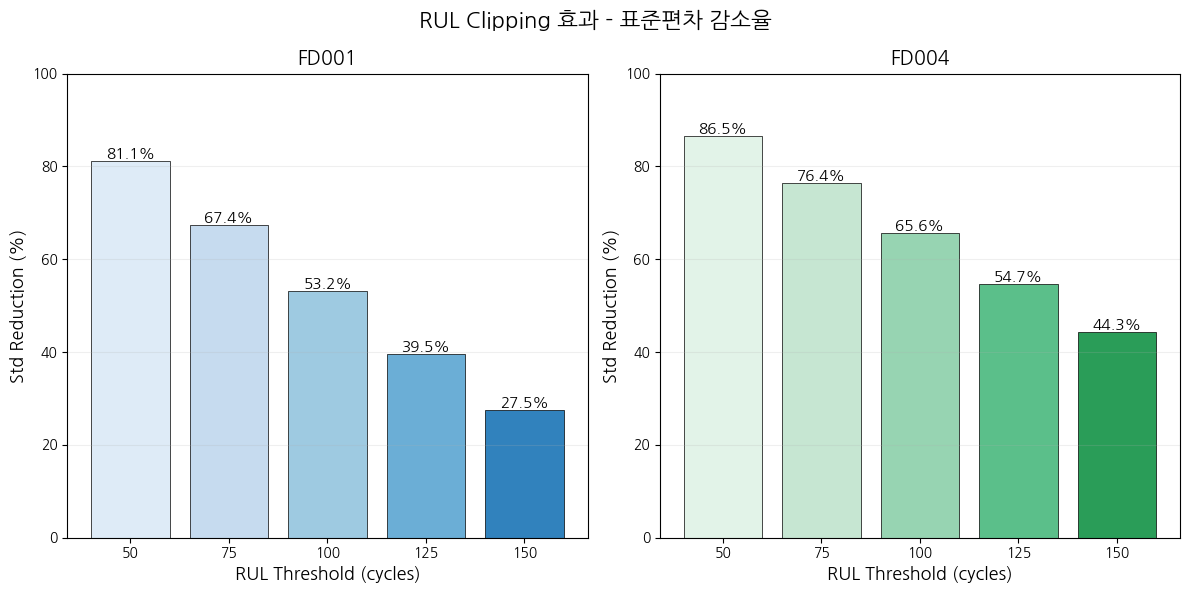

In [13]:
# RUL clipping 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('RUL Clipping 효과 - 표준편차 감소율', fontsize=16, fontweight='bold')

thresholds = [50, 75, 100, 125, 150]

# FD001
reductions_fd001 = []
for threshold in thresholds:
    clipped = apply_rul_clipping(original_fd001.copy(), threshold)
    reduction = (original_fd001['RUL'].std() - clipped['RUL'].std()) / original_fd001['RUL'].std() * 100
    reductions_fd001.append(reduction)

ax1 = axes[0]
bars1 = ax1.bar(range(len(thresholds)), reductions_fd001,
                color=['#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd'],
                edgecolor='black', linewidth=0.5)

# 값 표시
for i, (bar, val) in enumerate(zip(bars1, reductions_fd001)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xlabel('RUL Threshold (cycles)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Std Reduction (%)', fontsize=13, fontweight='bold')
ax1.set_title('FD001', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(thresholds)))
ax1.set_xticklabels([f'{t}' for t in thresholds])
ax1.set_ylim([0, 100])
ax1.grid(alpha=0.2, axis='y')

# FD004
reductions_fd004 = []
for threshold in thresholds:
    clipped = apply_rul_clipping(original_fd004.copy(), threshold)
    reduction = (original_fd004['RUL'].std() - clipped['RUL'].std()) / original_fd004['RUL'].std() * 100
    reductions_fd004.append(reduction)

ax2 = axes[1]
bars2 = ax2.bar(range(len(thresholds)), reductions_fd004,
                color=['#e2f3e8', '#c6e6d2', '#97d4b2', '#5bbf8a', '#2a9d58'],
                edgecolor='black', linewidth=0.5)

for i, (bar, val) in enumerate(zip(bars2, reductions_fd004)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('RUL Threshold (cycles)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Std Reduction (%)', fontsize=13, fontweight='bold')
ax2.set_title('FD004', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(thresholds)))
ax2.set_xticklabels([f'{t}' for t in thresholds])
ax2.set_ylim([0, 100])
ax2.grid(alpha=0.2, axis='y')

plt.tight_layout()
plt.show()

## 2) Scaling

In [14]:
results_scaling = {'FD001': {}, 'FD004': {}}

for dataset_name in ['FD001', 'FD004']:
    if dataset_name == 'FD001':
        train_data = load_cmapss_data(FD001_PATH)
        test_data = load_cmapss_data(FD001_TEST_PATH)
        test_rul = load_test_rul(FD001_RUL_PATH)
    else:
        train_data = load_cmapss_data(FD004_PATH)
        test_data = load_cmapss_data(FD004_TEST_PATH)
        test_rul = load_test_rul(FD004_RUL_PATH)

    for method_name, method_func in SCALING_METHODS.items():

        if method_name == 'none':
            train_scaled = train_data.copy()
            test_scaled = test_data.copy()
        else:
            train_scaled = method_func(train_data.copy(), ALL_SENSORS)
            test_scaled = method_func(test_data.copy(), ALL_SENSORS)

        X_train, y_train = prepare_lstm_data(train_scaled, ALL_SENSORS, WINDOW_SIZE)
        X_test, _ = prepare_lstm_data(test_scaled, ALL_SENSORS, WINDOW_SIZE)

        model, history = train_lstm_model(X_train, y_train, verbose=0)

        y_pred = model.predict(X_test, verbose=0).flatten()
        y_pred, valid_units = extract_last_predictions(y_pred, test_scaled, WINDOW_SIZE)

        max_unit = len(test_rul)
        valid_units_filtered = [u for u in valid_units if u <= max_unit]
        test_rul = np.array([test_rul[u-1] for u in valid_units_filtered])
        y_pred = y_pred[:len(valid_units_filtered)]

        rmse = np.sqrt(mean_squared_error(test_rul, y_pred))
        mae = mean_absolute_error(test_rul, y_pred)

        results_scaling[dataset_name][method_name] = {
            'rmse': float(rmse),
            'mae': float(mae),
            'n_units': len(valid_units),
            'total_units': len(test_rul),
            'skipped_units': len(test_rul) - len(valid_units)
        }

with open('results_scaling_lstm.json', 'w') as f:
    json.dump(results_scaling, f, indent=2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

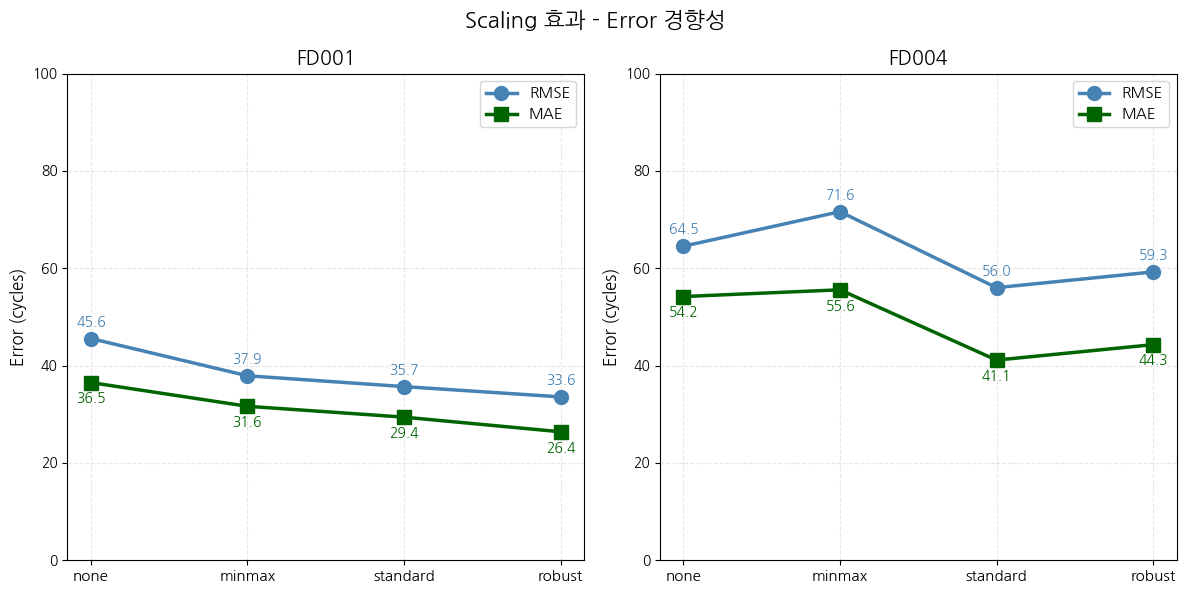

In [15]:
# Scaling 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Scaling 효과 - Error 경향성',
             fontsize=16, fontweight='bold')

methods = list(SCALING_METHODS.keys())
x_pos = np.arange(len(methods))

for idx, dataset in enumerate(['FD001', 'FD004']):
    ax = axes[idx]

    # 데이터
    rmse_list = [results_scaling[dataset][m]['rmse'] for m in methods]
    mae_list = [results_scaling[dataset][m]['mae'] for m in methods]

    # Line plot
    line1 = ax.plot(x_pos, rmse_list,
                    marker='o', markersize=10,
                    linewidth=2.5,
                    color='steelblue',
                    label='RMSE')

    line2 = ax.plot(x_pos, mae_list,
                    marker='s', markersize=10,
                    linewidth=2.5,
                    color='darkgreen',
                    label='MAE')

    # 값 표시
    for i, (rmse, mae) in enumerate(zip(rmse_list, mae_list)):
        ax.text(i, rmse + 2, f'{rmse:.1f}',
               ha='center', va='bottom',
               fontsize=10, fontweight='bold', color='steelblue')
        ax.text(i, mae - 2, f'{mae:.1f}',
               ha='center', va='top',
               fontsize=10, fontweight='bold', color='darkgreen')

    ax.set_title(f'{dataset}', fontweight='bold', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, fontsize=11)
    ax.set_ylabel('Error (cycles)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 3) Filtering

In [16]:
# 신호처리 평가
test_sensors = ['s_2', 's_7', 's_11', 's_15', 's_20']
results_filter_signal = {'FD001': {}, 'FD004': {}}

for dataset_name in ['FD001', 'FD004']:
    if dataset_name == 'FD001':
        train_data = load_cmapss_data(FD001_PATH)
    else:
        train_data = load_cmapss_data(FD004_PATH)

    sample_unit = train_data[train_data['unit'] == 1].copy()

    for method_name, method_func in FILTER_METHODS.items():

        if method_name == 'none':
            filtered = sample_unit.copy()
        else:
            filtered = method_func(sample_unit.copy(), test_sensors)

        sensor_stats = {}
        for sensor in test_sensors:
            orig_std = sample_unit[sensor].std()
            filt_std = filtered[sensor].std()
            std_reduction = (orig_std - filt_std) / orig_std * 100

            sensor_stats[sensor] = {'std_reduction_pct': float(std_reduction)}

        avg_reduction = np.mean([s['std_reduction_pct'] for s in sensor_stats.values()])

        results_filter_signal[dataset_name][method_name] = {
            'avg_std_reduction': float(avg_reduction),
            'sensors': sensor_stats
        }

with open('results_filter_signal.json', 'w') as f:
    json.dump(results_filter_signal, f, indent=2)

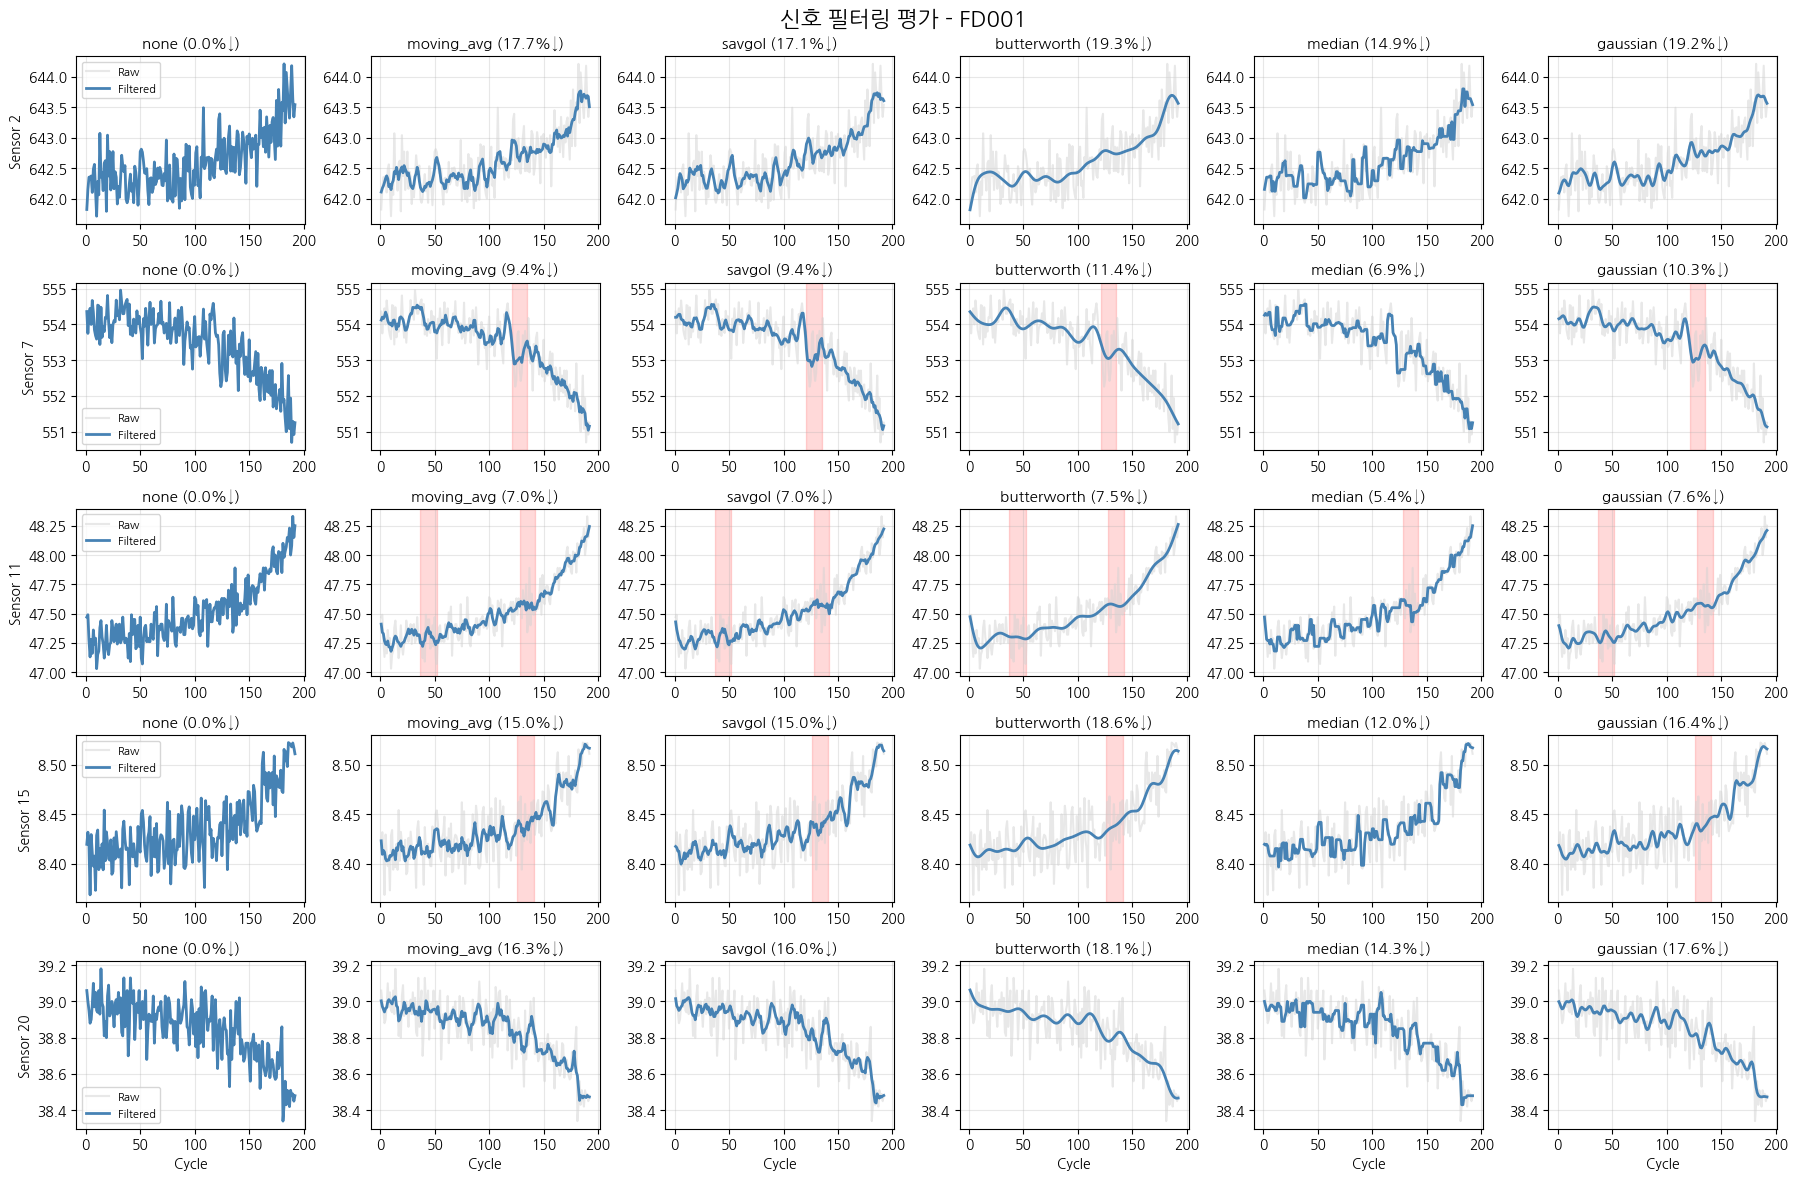

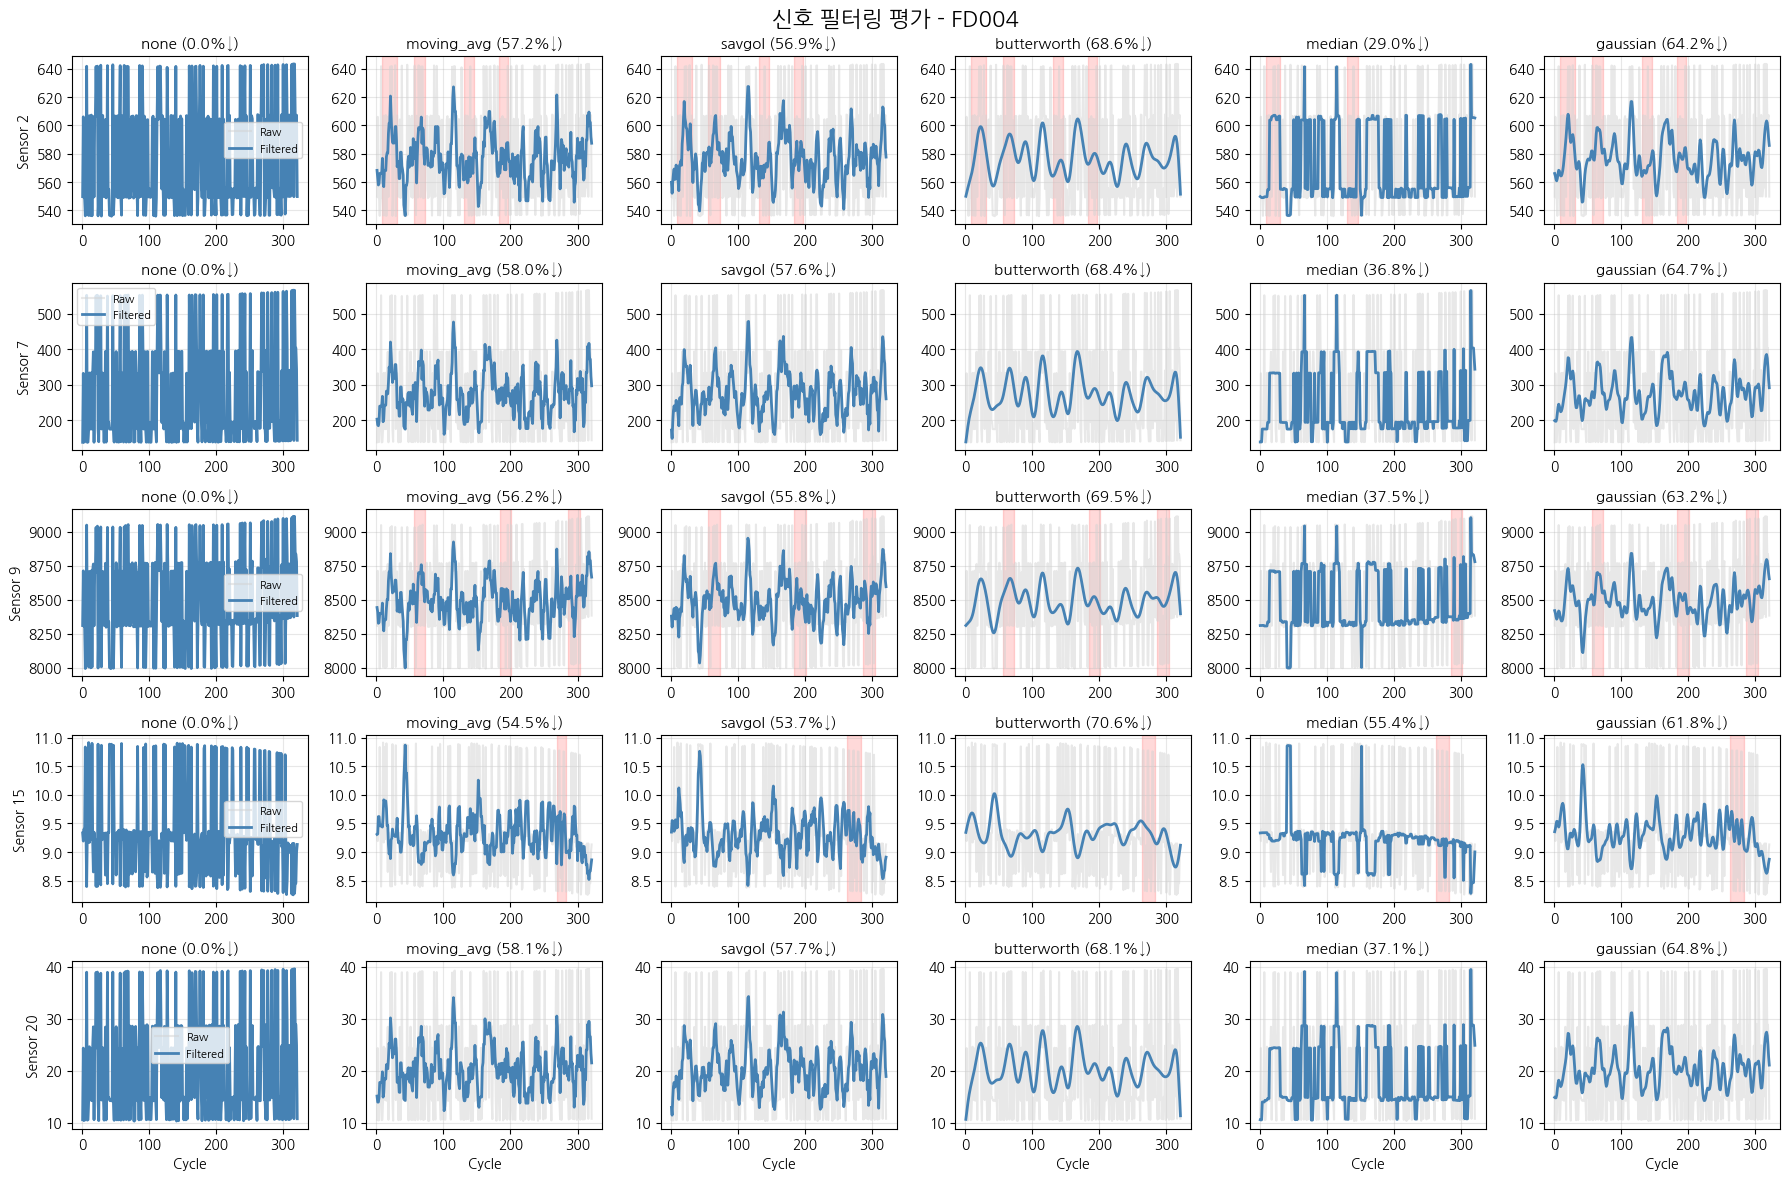

In [17]:
DATA_CONFIG = {
    'FD001': {
        'path': FD001_PATH,
        'display_sensors': ['s_2', 's_7', 's_11', 's_15', 's_20'],
        'sensor_names':   ['Sensor 2', 'Sensor 7', 'Sensor 11', 'Sensor 15', 'Sensor 20']
    },
    'FD004': {
        'path': FD004_PATH,
        'display_sensors': ['s_2', 's_7', 's_9', 's_15', 's_20'],
        'sensor_names':   ['Sensor 2', 'Sensor 7', 'Sensor 9', 'Sensor 15', 'Sensor 20']
    }
}

for dataset_name, cfg in DATA_CONFIG.items():
    # 데이터 로드
    train_data = load_cmapss_data(cfg['path'])
    sample_unit = train_data[train_data['unit'] == 1].copy()

    display_sensors = cfg['display_sensors']
    sensor_names    = cfg['sensor_names']

    # Figure 생성
    fig, axes = plt.subplots(len(display_sensors), len(FILTER_METHODS),
                             figsize=(18, 12))
    fig.suptitle(f'신호 필터링 평가 - {dataset_name}',
                 fontsize=16, fontweight='bold')

    # 센서 × 필터 루프
    for sensor_idx, (sensor, sensor_name) in enumerate(zip(display_sensors, sensor_names)):

        for filter_idx, (filter_name, filter_func) in enumerate(FILTER_METHODS.items()):
            ax = axes[sensor_idx, filter_idx]

            # 필터 적용
            if filter_name == 'none':
                filtered = sample_unit.copy()
            else:
                filtered = filter_func(sample_unit.copy(), [sensor])

            # 통계 계산 (노이즈 감소율)
            orig_std = sample_unit[sensor].std()
            filt_std = filtered[sensor].std()
            reduction = (orig_std - filt_std) / orig_std * 100

            # Raw / Filtered 신호
            cycles      = sample_unit['cycle'].values
            raw_values  = sample_unit[sensor].values
            filt_values = filtered[sensor].values

            ax.plot(cycles, raw_values, alpha=0.5, linewidth=1.5,label='Raw', color='lightgray')
            ax.plot(cycles, filt_values, linewidth=2,label='Filtered', color='steelblue')

            # 지연 구간 탐지
            delay_regions = detect_delay_curvature(raw_values, filt_values, threshold_scale=0.6, cycle_duration=15)

            # 지연 구간 표시
            if len(delay_regions) > 0:
                for (start, end) in delay_regions:
                    ax.axvspan(cycles[start], cycles[end - 1],alpha=0.15, color='red', label='지연 구간')

            # 제목 / 축 레이블 / 범례
            ax.set_title(f'{filter_name} ({reduction:.1f}%↓)',
                         fontsize=11, fontweight='bold')

            if filter_idx == 0:
                ax.set_ylabel(sensor_name, fontsize=10, fontweight='bold')

            if sensor_idx == len(display_sensors) - 1:
                ax.set_xlabel('Cycle', fontsize=10)

            if filter_idx == 0:
                ax.legend(fontsize=8, loc='best')

            ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


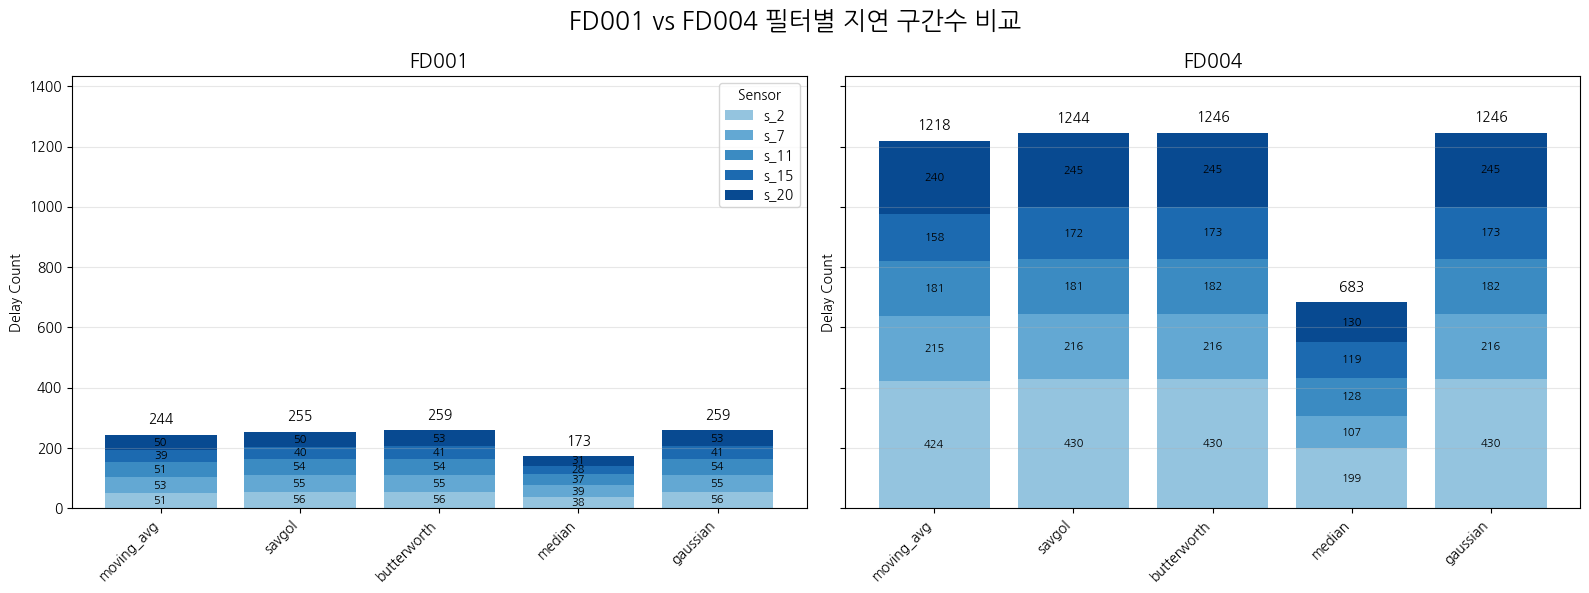

In [18]:
sensors = ['s_2', 's_7', 's_11', 's_15', 's_20']

train_fd001 = load_cmapss_data(FD001_PATH)
train_fd004 = load_cmapss_data(FD004_PATH)

fd001_delay_counts = count_delay_regions(
    train_fd001, sensors, FILTER_METHODS, detect_delay_curvature,
    threshold_scale=0.6, cycle_duration=15
)

fd004_delay_counts = count_delay_regions(
    train_fd004, sensors, FILTER_METHODS, detect_delay_curvature,
    threshold_scale=0.6, cycle_duration=15
)

plot_delay_compare(
    fd001_delay_counts,
    fd004_delay_counts,
    sensors,
    title="FD001 vs FD004 필터별 지연 구간수 비교"
)

## 4) Feature Engineering

In [21]:
# LSTM 평가
results_feature = {'FD001': {}, 'FD004': {}}

for dataset_name in ['FD001', 'FD004']:
    # 데이터 로드
    if dataset_name == 'FD001':
        train_data = load_cmapss_data(FD001_PATH)
        test_data = load_cmapss_data(FD001_TEST_PATH)
        test_rul = load_test_rul(FD001_RUL_PATH)
        scaler_method = apply_robust_scaling
        scaler_name = "Robust"
    else:
        train_data = load_cmapss_data(FD004_PATH)
        test_data = load_cmapss_data(FD004_TEST_PATH)
        test_rul = load_test_rul(FD004_RUL_PATH)
        scaler_method = apply_robust_scaling
        scaler_name = "Robust"

    for method_name, method_func in FEATURE_ENGINEERING_METHODS.items():
        # Feature Engineering 적용
        if method_name == 'none':
            train_feat = train_data.copy()
            test_feat = test_data.copy()
            features = ALL_SENSORS
        else:
            train_feat, features = method_func(train_data.copy(), ALL_SENSORS)
            test_feat, _ = method_func(test_data.copy(), ALL_SENSORS)

        train_scaled = scaler_method(train_feat, features)
        test_scaled = scaler_method(test_feat, features)

        X_train, y_train = prepare_lstm_data(train_scaled, features, WINDOW_SIZE)
        X_test, _ = prepare_lstm_data(test_scaled, features, WINDOW_SIZE)

        model, history = train_lstm_model(X_train, y_train, verbose=0)

        y_pred = model.predict(X_test, verbose=0).flatten()
        y_pred, valid_units = extract_last_predictions(y_pred, test_scaled, WINDOW_SIZE)

        max_unit = len(test_rul)
        valid_units_filtered = [u for u in valid_units if u <= max_unit]
        test_rul = np.array([test_rul[u-1] for u in valid_units_filtered])
        y_pred = y_pred[:len(valid_units_filtered)]

        rmse = np.sqrt(mean_squared_error(test_rul, y_pred))
        mae = mean_absolute_error(test_rul, y_pred)

        results_feature[dataset_name][method_name] = {
            'rmse': float(rmse),
            'mae': float(mae),
            'n_features': len(features),
            'scaler': scaler_name,
            'n_units': len(valid_units),
            'total_units': len(test_rul),
            'skipped_units': len(test_rul) - len(valid_units)
        }

# 결과 저장
with open('results_feature_lstm.json', 'w') as f:
    json.dump(results_feature, f, indent=2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

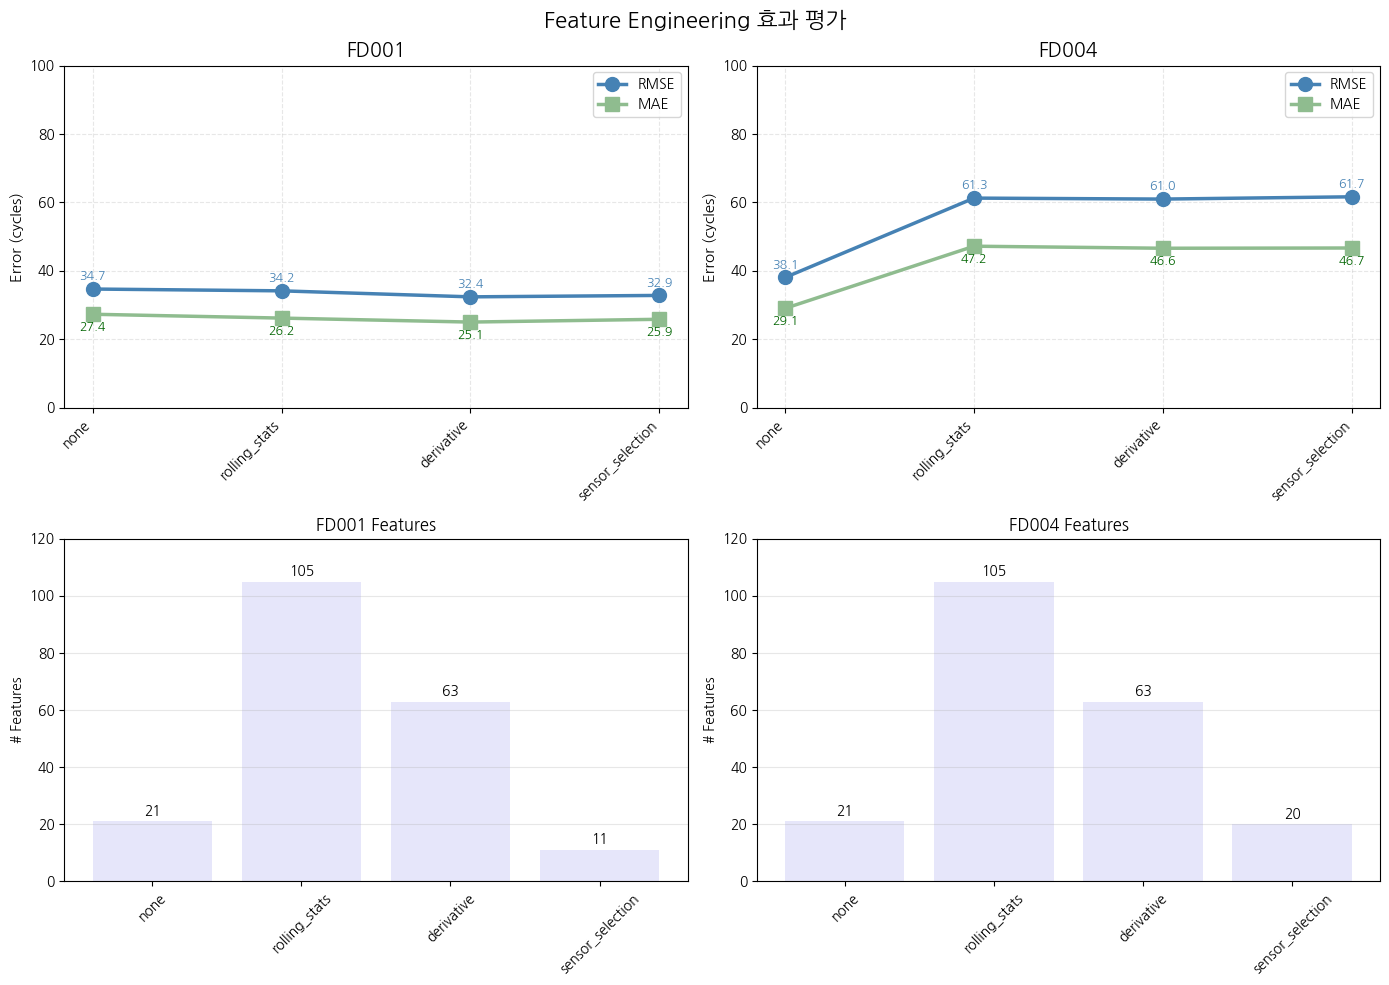

In [22]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Engineering 효과 평가', fontsize=16, fontweight='bold')

methods = list(FEATURE_ENGINEERING_METHODS.keys())
x_pos = np.arange(len(methods))

# RMSE, MAE
for idx, dataset in enumerate(['FD001', 'FD004']):
    ax = axes[0, idx]

    # 데이터
    rmse_list = [results_feature[dataset][m]['rmse'] for m in methods]
    mae_list = [results_feature[dataset][m]['mae'] for m in methods]

    # Line Plot
    ax.plot(x_pos, rmse_list,
           marker='o', markersize=10,
           linewidth=2.5,
           color='steelblue',
           label='RMSE',
           zorder=2)

    ax.plot(x_pos, mae_list,
           marker='s', markersize=10,
           linewidth=2.5,
           color='#8FBC8F',
           label='MAE',
           zorder=2)

    # 값 및 개선율 표시
    baseline_rmse = rmse_list[0]
    baseline_mae = mae_list[0]

    for i, (rmse, mae) in enumerate(zip(rmse_list, mae_list)):
        # RMSE 값
        ax.text(i, rmse + 2, f'{rmse:.1f}',
               ha='center', va='bottom',
               fontsize=9, fontweight='bold',
               color='steelblue')

        # MAE 값
        ax.text(i, mae - 2, f'{mae:.1f}',
               ha='center', va='top',
               fontsize=9, fontweight='bold',
               color='darkgreen')

    # 제목 및 설정
    ax.set_title(f'{dataset}', fontweight='bold', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Error (cycles)', fontsize=11, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(alpha=0.3, linestyle='--', zorder=0)

# Feature 개수
for idx, dataset in enumerate(['FD001', 'FD004']):
    ax = axes[1, idx]
    feat_counts = [results_feature[dataset][m]['n_features'] for m in methods]

    ax.bar(x_pos, feat_counts, color='lavender')

    for i, count in enumerate(feat_counts):
        ax.text(i, count + 2, f'{count}', ha='center')

    ax.set_title(f'{dataset} Features', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(methods, rotation=45)
    ax.set_ylabel('# Features')
    ax.set_ylim([0, 120])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()